In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit, float64, int64

In [2]:
@jit(nopython=True)
def simulate_CDDM(threshold, lamda, delta, sd, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while -(threshold / (1 + lamda*rt)) < x and x < (threshold / (1 + lamda*rt)):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= (threshold / (1 + lamda*rt)):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch, np.random.normal(ndt, sd)

In [3]:
@jit(nopython=True)
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

@jit(nopython=True)
def psi(threshold, lamda, t, z, tau, delta, sigma=1):
    db = (-lamda*threshold)/(1 + lamda*t)**2
    term1 = 0.5*f(threshold /(1 + lamda*t), t, z, tau, delta, sigma)
    term2 = db - delta - ((threshold /(1 + lamda*t)) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

@jit(nopython=True)
def fpt(threshold, lamda, delta, z=0, sigma=1, dt=0.02, T_max=5):
    gu = np.zeros((int(T_max/dt)+2,))
    gl = np.zeros((int(T_max/dt)+2,))
    T = np.zeros((int(T_max/dt)+2,))
    
    gu[1] = -2*psi(threshold, lamda, dt, z, 0, delta, sigma)
    gl[1] =  2*psi(-threshold, lamda, dt, z, 0, delta, sigma)
    T[1] = dt
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi( threshold, lamda, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(-threshold, lamda, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if (threshold /(1 + lamda*j*dt)) == 0:
                continue
            
            psi_n_j_pp = psi( threshold, lamda, n*dt,  threshold /(1 + lamda*j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi( threshold, lamda, n*dt, -threshold /(1 + lamda*j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(-threshold, lamda, n*dt,  threshold /(1 + lamda*j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(-threshold, lamda, n*dt, -threshold /(1 + lamda*j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu[n] = su
        gl[n] = sl
        T[n] = (n*dt)
    return gu, gl, T

In [4]:
@jit(nopython=True)
def CDDM_likelihood(prms, RT, Z):
    delta = prms[2]
    sig = prms[3]
    t0 = prms[4]
    
    tt = np.maximum(np.abs(RT) - t0, 0)
    
    T_max = np.max(np.abs(RT))
    gu, gl, TT = fpt(prms[0], prms[1], delta, z=0, dt=0.02, T_max=T_max)

    gtup = np.interp(tt, TT, gu)
    gtlp = np.interp(tt, TT, gl)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            if RT[i]>=0:
                
                ll += 0.5 * (Z[i] - t0)**2/sig**2 + 0.5 * np.log(2*np.pi*sig**2)
                
                if gtup[i]>1e-14:
                    ll += -np.log(gtup[i])
                else:
                    ll += -np.log(1e-14)
            else:
                
                ll += 0.5 * (Z[i] - t0)**2/sig**2 + 0.5 * np.log(2*np.pi*sig**2)
                
                if gtlp[i]>1e-14:
                    ll += -np.log(gtlp[i])
                else:
                    ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [5]:
n_trials = 500
recovery_dic = {'a_true': [],
                'a_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'delta_true': [],
                'delta_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[],
                'ndt_true':[],
                'ndt_estimate':[]}

In [6]:
for n in tqdm(range(300)):
    threshold = np.random.uniform(1.5, 4)
    lamda = np.random.uniform(0.1, 2)
    delta = np.random.uniform(0, 3)
    
    ndt = np.random.uniform(0.05, 1.5)
    sd = np.random.uniform(ndt/5, ndt/3)
    
    RT = []
    Z = []
    
    for i in range(n_trials):
        rt, z = simulate_CDDM(threshold, lamda, delta, sd, ndt=ndt)
        RT.append(rt)
        Z.append(z)
        
    RT = np.array(RT)
    Z = np.array(Z)
    
    ans_cddm = differential_evolution(CDDM_likelihood,
                                      args=(RT, Z), 
                                      bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                              (0.005, 0.5), (0.05, 1.5)])
    ans_cddm = minimize(CDDM_likelihood,
                        args=(RT, Z),
                        method='Nelder-Mead',
                        x0=ans_cddm.x,
                        bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                (0.005, 0.5), (0.05, 1.5)])

    recovery_dic['a_true'].append(threshold)
    recovery_dic['a_estimate'].append(ans_cddm.x[0])
    recovery_dic['lambda_true'].append(lamda)
    recovery_dic['lambda_estimate'].append(ans_cddm.x[1])
    recovery_dic['delta_true'].append(delta)
    recovery_dic['delta_estimate'].append(ans_cddm.x[2])
    recovery_dic['sigma_true'].append(sd)
    recovery_dic['sigma_estimate'].append(ans_cddm.x[3])
    recovery_dic['ndt_true'].append(ndt)
    recovery_dic['ndt_estimate'].append(ans_cddm.x[4])

100%|█████████████████████████████████████████| 300/300 [04:46<00:00,  1.05it/s]


In [7]:
recovery_df = pd.DataFrame(recovery_dic)

In [8]:
file_name = '_data/Hyperbolic_rec_{}.csv'.format(n_trials)
old_recovery_data = pd.read_csv(file_name, index_col=0)
recovery_df = pd.concat([old_recovery_data, 
                         recovery_df]).reset_index(drop=True)
recovery_df.to_csv(file_name)

In [9]:
print(recovery_df.shape[0])
recovery_df.corr()

1000


,a_true,a_estimate,lambda_true,lambda_estimate,delta_true,delta_estimate,sigma_true,sigma_estimate,ndt_true,ndt_estimate
a_true,1.000000,0.948449,0.001077,-0.029555,-0.039724,-0.030683,-0.019791,-0.018641,-0.017311,-0.015479
a_estimate,0.948449,1.000000,-0.035136,0.059849,-0.045282,-0.052920,-0.000937,0.000202,-0.003607,-0.005189
lambda_true,0.001077,-0.035136,1.000000,0.883706,0.027748,0.026602,0.045952,0.045228,0.022563,0.023859
lambda_estimate,-0.029555,0.059849,0.883706,1.000000,0.015263,-0.029965,0.083491,0.082264,0.056333,0.055020
delta_true,-0.039724,-0.045282,0.027748,0.015263,1.000000,0.989268,-0.001031,-0.000080,-0.014387,-0.014409
delta_estimate,-0.030683,-0.052920,0.026602,-0.029965,0.989268,1.000000,-0.011489,-0.010507,-0.023517,-0.023340
sigma_true,-0.019791,-0.000937,0.045952,0.083491,-0.001031,-0.011489,1.000000,0.997816,0.960811,0.960347
sigma_estimate,-0.018641,0.000202,0.045228,0.082264,-0.000080,-0.010507,0.997816,1.000000,0.958348,0.957889
ndt_true,-0.017311,-0.003607,0.022563,0.056333,-0.014387,-0.023517,0.960811,0.958348,1.000000,0.999680
ndt_estimate,-0.015479,-0.005189,0.023859,0.055020,-0.014409,-0.023340,0.960347,0.957889,0.999680,1.000000


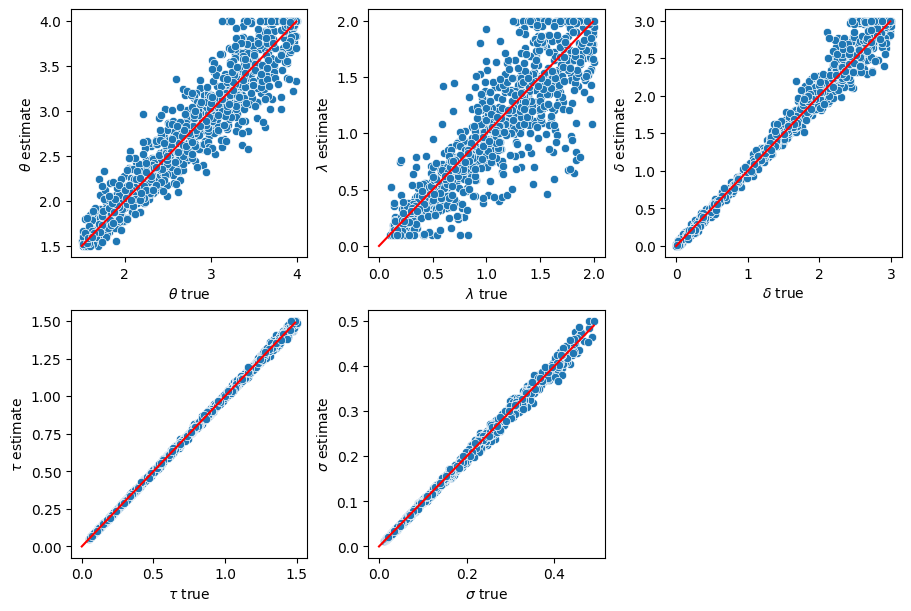

In [10]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 4, 0.01), np.arange(1.5, 4, 0.01), c='red')
sns.scatterplot(x='a_true', y='a_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(0, 3, 0.01), np.arange(0, 3, 0.01), c='red')
sns.scatterplot(x='delta_true', y='delta_estimate', data=recovery_df);
plt.xlabel(r'$\delta$ true')
plt.ylabel(r'$\delta$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate')

plt.subplot(235)
plt.plot(np.arange(0, 0.5, 0.01), np.arange(0, 0.5, 0.01), c='red')
sns.scatterplot(x='sigma_true', y='sigma_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');